In [ ]:
# default_exp generalized_linear_models

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy.optimize import fmin
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')

RANDOM_SEED = 20090425

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
medals = pd.read_csv('data/medals.csv')
medals.head()

,medals,population,oecd,log_population
0,1,96165,0,11.473821
1,1,281584,0,12.548186
2,6,2589043,0,14.766799
3,25,10952046,0,16.209037
4,41,18348078,1,16.725035


<AxesSubplot:xlabel='population', ylabel='medals'>

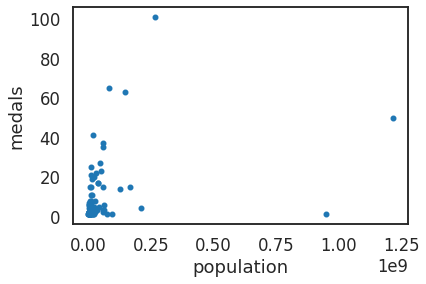

In [ ]:
medals.plot(x='population', y='medals', kind='scatter')

<AxesSubplot:xlabel='log_population', ylabel='medals'>

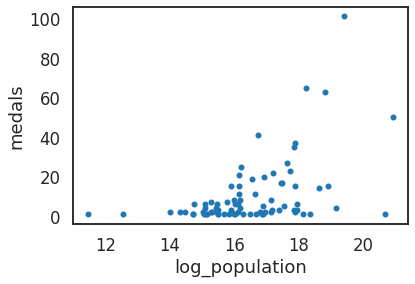

In [ ]:
medals.plot(x='log_population', y='medals', kind='scatter')

### Generalized linear models

In [ ]:
x,y = medals.log_population, medals.medals

with pm.Model() as medals_linear:
    intercept = pm.Normal('intercept', 0, sd=100)
    slope = pm.Normal('slope', 0, sd=100)
    σ = pm.HalfCauchy('σ', 1)
    
    μ = intercept + slope*x
    score = pm.Normal('score', μ, sd=σ, observed=y)
    
    samples = pm.sample(1000, random_seed=RANDOM_SEED)

<ipython-input-9-1e82e3af37bd>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  samples = pm.sample(1000, random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, slope, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6302377980373235, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
yhat = samples['intercept'].mean() + samples['slope'].mean() * np.linspace(10,22)

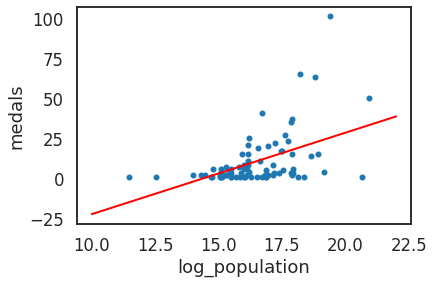

In [ ]:
ax = medals.plot(x='log_population', y='medals', kind='scatter')
ax.plot(np.linspace(10,22), yhat, color='red', linewidth=2)

### Using poisson distribution
$$\log L = \sum_{i=1}^n -\exp(X_i\beta) + Y_i (X_i \beta)- \log(Y_i!)$$

In [ ]:
medals[['log_population']].assign(intercept=1)

,log_population,intercept
0,11.473821,1
1,12.548186,1
2,14.766799,1
3,16.209037,1
4,16.725035,1
...,...,...
74,17.890545,1
75,19.162511,1
76,18.126388,1
77,18.359656,1


In [ ]:
# Poisson negative log-likelihood
poisson_loglike = lambda β, X, y: -(-np.exp(X.dot(β)) + y*X.dot(β)).sum()

# Test

poisson_loglike([0,1], medals[['log_population']].assign(intercept=1), medals.medals)

-627.2557355517357

In [ ]:
b1, b0 = fmin(poisson_loglike, [0,1], args=(medals[['log_population']].assign(intercept=1).values, 
                                            medals.medals.values))

Optimization terminated successfully.
         Current function value: -1381.299433
         Iterations: 68
         Function evaluations: 131


In [ ]:
b0, b1

(-5.297302917060439, 0.44873025169011005)

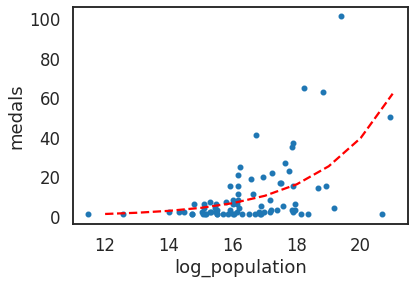

In [ ]:
ax = medals.plot(x='log_population', y='medals', kind='scatter')
xvals = np.arange(12, 22)
ax.plot(xvals, np.exp(b0 + b1*xvals), 'r--')